# Regresión Lineal - Recargado

En este notebook pondrás en práctiva la aplicación de modelos de regresión lineal a problemas no lineales. También incroporarás la técnica de regularización para evitar el overfitting, un problema común en este tipo de enfoques.


## 1. Regresión No-Lineal

Vamos a comenzar, como siempre hacemos en estos temas, con un ejemplo controlado. Supongamos que tenenos un dataset con dos atributos, $x$ e $y$, y la relación entre ellos es $y = -2x^4+3x^2+1$


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

La siguiente celda genera nuestro dataset sintético. Le sumamos ruido para simular una situación más realista.

In [ ]:
n = 300
x = np.linspace(-1,1,n)
y_real = -1.5*x**4+3*x**2+1
y = y_real + 0.1*np.random.randn(n)

Graficamos la muestra y la curva teórica.

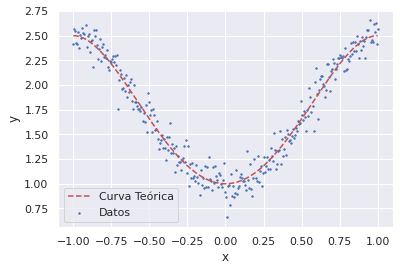

In [ ]:
plt.scatter(x,y, s = 2, label = 'Datos')
plt.plot(x, y_real, '--',label ='Curva Teórica', c = 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Vamos a entrenar un modelo de Regresión Lineal, al que llamaremos `reg_1`. Primero, vamos a definir nuestro dataset `X` (notar la diferencia con la variable `x`)-> lo reordeno en forma de vector para que sea interpretable para el modelo

 Luego, hacer un `train_test_split`, y entrenar la regresión lineal.

In [ ]:
from sklearn.model_selection import train_test_split

X = x.reshape(-1,1) # la estructura que necesita el train test, es llevarlo a formato de dataset. le doy el formato con esto. las dimensiones es (algo, 1) el ,1 explicito
#antes era un vector ahora lo hago columna
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42) #proporcion 75-25

In [ ]:
from sklearn.linear_model import LinearRegression
reg_1 = LinearRegression()

In [ ]:
reg_1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_train_pred_1 = reg_1.predict(X_train)
y_test_pred_1 = reg_1.predict(X_test)

Graficamos la regresión obtenida.

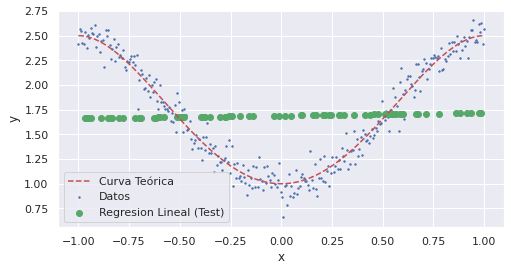

In [ ]:
plt.figure(figsize = (8,4))
plt.scatter(x,y, s = 2, label = 'Datos')
plt.plot(x, y_real, '--',label ='Curva Teórica', c = 'r')
plt.scatter(X_test,y_test_pred_1,label ='Regresion Lineal (Test)', c = 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Ya en el gráfico podemos ver que la regresión obtenida es un modelo malo, ya que no captura correctamente la relación entre $x$ e $y$, salvo por, prácticamente, su valor medio.

De todas formas, calculamos el error RMSE, hacemos un histograma de los errores en el conjunto de Train y Test, y una curva `y` vs `y_pred`

Raíz del error cuadrático medio en Train: 0.5518573518392327
Raíz del error cuadrático medio en Test: 0.5201472447277457


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


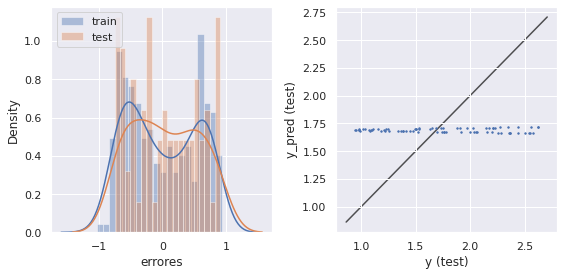

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_1))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_1))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_1, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_1, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_1, s =2) #sobre la diagonal es lo ideal donde tienen que estar los puntos para que el modelo sea bueno

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

Tal cómo sucedió en ejemplo de la bitácora, el modelo parece muy lejos de la realidad. Veamos si lo podemos mejorar.

Para facilitar la comprensión del código, vamos a crear una función que nos sirva para evaluar modelos de regresión.

In [ ]:
def evaluar_regresion(model,x,y, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (12,4))
    plt.subplot(1,3,1)
    plt.scatter(x,y, s = 2, label = 'Datos')
    plt.plot(x, y_real, '--',label ='Curva Teórica', c = 'r')
    
    list1, list2 = zip(*sorted(zip(X_train[:,0], y_train_pred)))
    plt.plot(list1, list2,label ='Regresión (train)')
    
    list1, list2 = zip(*sorted(zip(X_test[:,0], y_test_pred)))
    plt.plot(list1, list2,label = 'Regresión (test)')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()


    plt.subplot(1,3,2)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,3,3)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

### 1.2 Atributos Polinómicos


Vamos a agregar al dataset, `X`, nuevos atributos polinómicos: $x^2, x^3$ y $x^4$  y volver a ajustar la regresión lineal.

Cada atributo lo vamos a agregar de a uno, y vamos a ver cómo se modifica la regresión. **Presta mucha atención al código**. Al agregar un atributo nuevo, ¿qué ocurría con la regresíon lineal?

In [ ]:
print(list(enumerate(range(1,6)))) #en el for seria, en el idx 0 va el numero 1

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]


REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia x**1
Los atributos tienen forma: (300, 1)
Raíz del error cuadrático medio en Train: 0.5518573518392327
Raíz del error cuadrático medio en Test: 0.5201472447277457


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


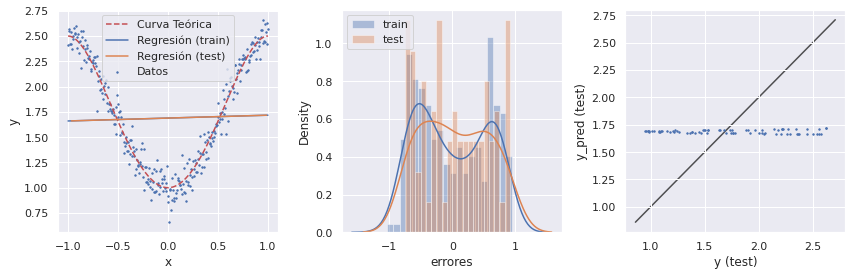

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia x**2
Los atributos tienen forma: (300, 2)
Raíz del error cuadrático medio en Train: 0.15429387455767152
Raíz del error cuadrático medio en Test: 0.17478640353816888


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


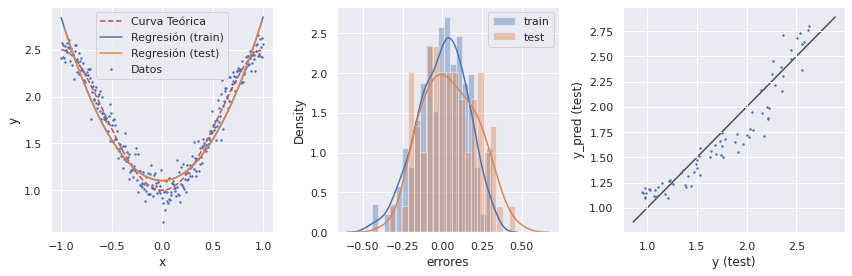

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia x**3
Los atributos tienen forma: (300, 3)
Raíz del error cuadrático medio en Train: 0.1542609972057048
Raíz del error cuadrático medio en Test: 0.175053846357404


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


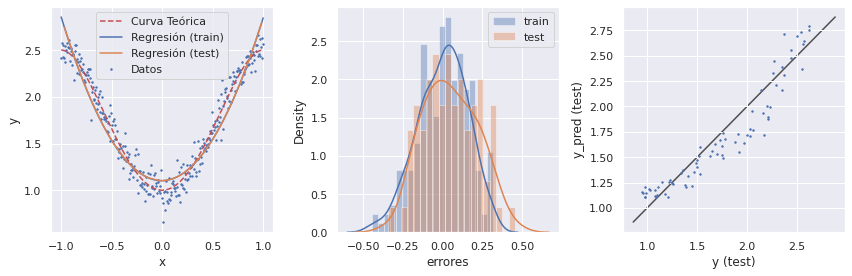

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 4
Agregamos atributos hasta la potencia x**4
Los atributos tienen forma: (300, 4)
Raíz del error cuadrático medio en Train: 0.10153942674326495
Raíz del error cuadrático medio en Test: 0.11940530553941522


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


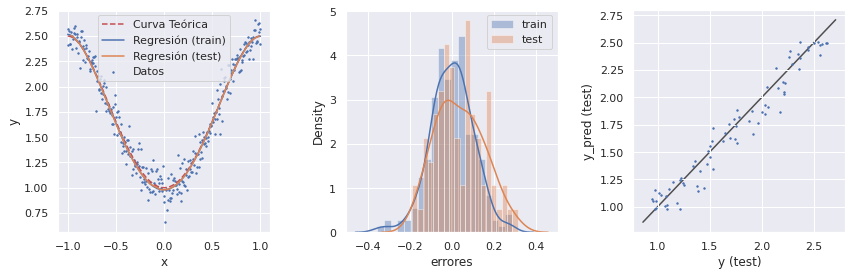

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 5
Agregamos atributos hasta la potencia x**5
Los atributos tienen forma: (300, 5)
Raíz del error cuadrático medio en Train: 0.10152259675078586
Raíz del error cuadrático medio en Test: 0.1196025978943445


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


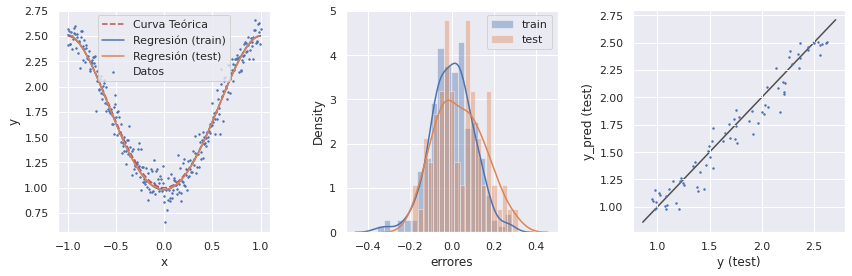

In [ ]:
for idx,potencia_maxima in enumerate(range(1,6)):
    print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {idx + 1}')
    print(f'Agregamos atributos hasta la potencia x**{potencia_maxima}')
    
    X = x.reshape(-1,1)
    for potencia in range(2,potencia_maxima+1):
        X = np.hstack((X,(x**potencia).reshape(-1,1)))  #es una forma de concatenar numpy arrays, en este caso ira concatenando los valores del polinomio de x https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
    print(f'Los atributos tienen forma: {X.shape}')
    
    #entrena el X con los atributos nuevos polinomicos, es decir x, x¨2, x¨3...
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    
    ### ENTRENAMOS
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    evaluar_regresion(reg, x,y, X_train, X_test, y_train, y_test)


#el for va a ir ajustando los valores de x con el polinomio. 
#se muestra el desempeño del rmse y cómo se austa la curva y los errores (tienden a minimizarse a mayor orden polinomico)
#a mayor orden, mas atributos usa el modelo para ajustar (llega un momento donde la ganancia del error es poco significativa)

Una aclaración sobre el código: es una buena práctica estandarizar los datos (normalizar) antes de entrenar una regresión lineal. No lo hicimos para no saturar (aún más) la explicación.


**Para Pensar - Challenge**

1. ¿Por que no parecen haber cambios entre el segundo y el tercer gráfico?¿Y entre el cuarto y el quinto?

El ajuste en los datos lo genera la función de orden más parecida órdenesa la forma de la distribución. Que es una funcion de potencia par.
$y = -2x^4+3x^2+1$
porque la relación funcional tiene grado máximo par, lo cual en el segundo y tercer grafico el que predomina es la fución par.

x´3 o x´5 no esta aportando a forma funcional en relacion a x´2 y x´4



    hay que mirar la forma de la funcion x"2 y X"3 y vemos que en los extremos no ajusta los datos con las curvas teoricas que usamos
    llevar a un orden mayor a 4 complejiza el modelo y no mejora ni la distribución de errores ni el y_pred vs y



2. Modifica el código de forma tal que imprima los coeficientes (pendientes y ordenada al origen) de cada regresión entrenada.


    modelo.intercept_ (ordenada al origen)
    modelo.coef_ (coeficientes polinomicos el orden de los coeficientes es x"1, x"2, x"3, x"4...

3. Agrega atributos de orden polinómico más alto y observa qué sucede. **Nota:** la modificación que tienes que hacer en el código es mínima. No tengas miedo de probar diferentes órdenes de magnitud.
    del orden 5 en adelante no cambia la forma del ajuste y el cambio en el error no es significativo

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia x**1
Los atributos tienen forma: (300, 1)
Los coeficiones polinomicos son [0.02859949] y su ordenada al origen 1.6887107776211077
Raíz del error cuadrático medio en Train: 0.5518573518392327
Raíz del error cuadrático medio en Test: 0.5201472447277457


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


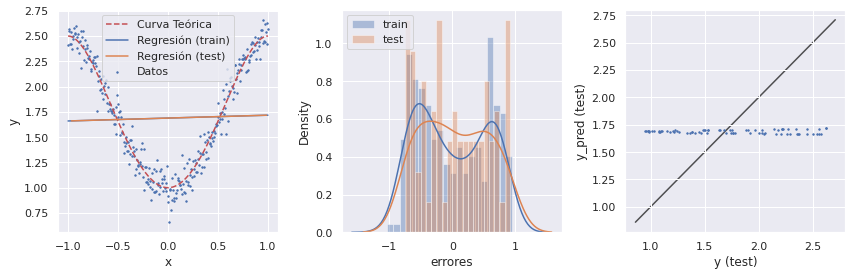

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia x**2
Los atributos tienen forma: (300, 2)
Los coeficiones polinomicos son [0.00318009 1.74688594] y su ordenada al origen 1.1021881332800636
Raíz del error cuadrático medio en Train: 0.15429387455767152
Raíz del error cuadrático medio en Test: 0.17478640353816888


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


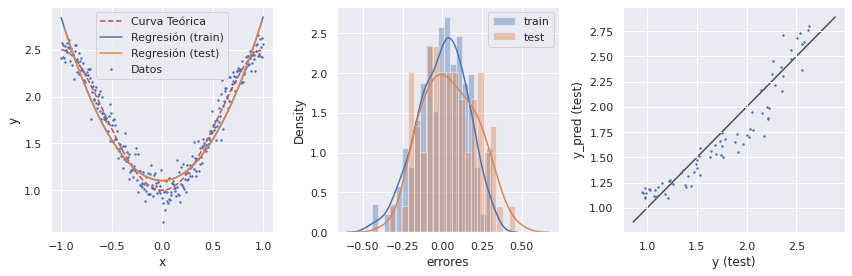

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia x**3
Los atributos tienen forma: (300, 3)
Los coeficiones polinomicos son [ 0.01612533  1.74689054 -0.0212244 ] y su ordenada al origen 1.102255624142453
Raíz del error cuadrático medio en Train: 0.1542609972057048
Raíz del error cuadrático medio en Test: 0.175053846357404


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


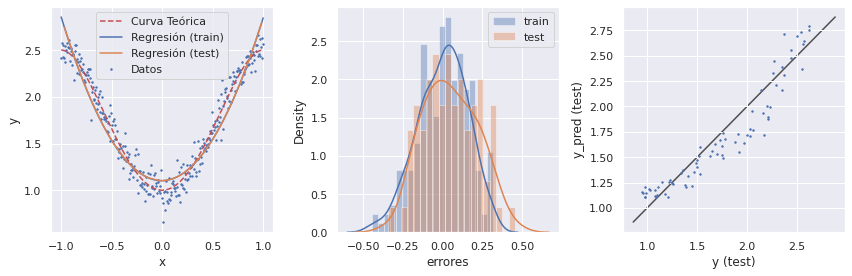

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 4
Agregamos atributos hasta la potencia x**4
Los atributos tienen forma: (300, 4)
Los coeficiones polinomicos son [ 0.02233436  3.03156334 -0.03202006 -1.50305357] y su ordenada al origen 0.9787593817798014
Raíz del error cuadrático medio en Train: 0.10153942674326495
Raíz del error cuadrático medio en Test: 0.11940530553941522


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


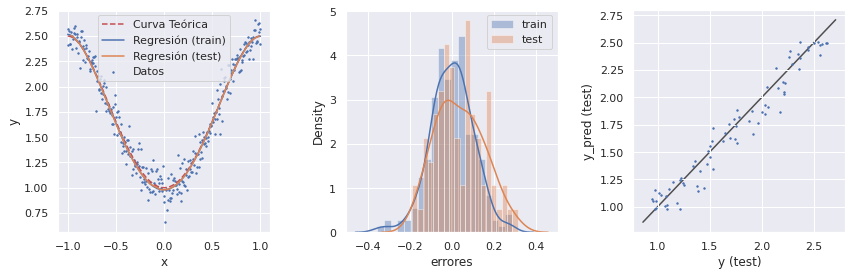

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 5
Agregamos atributos hasta la potencia x**5
Los atributos tienen forma: (300, 5)
Los coeficiones polinomicos son [ 0.03370173  3.03155987 -0.08421932 -1.50293688  0.04661375] y su ordenada al origen 0.9787807535689653
Raíz del error cuadrático medio en Train: 0.10152259675078586
Raíz del error cuadrático medio en Test: 0.1196025978943445


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


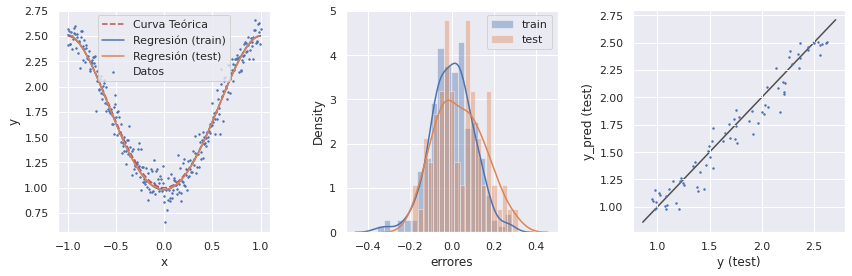

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 6
Agregamos atributos hasta la potencia x**6
Los atributos tienen forma: (300, 6)
Los coeficiones polinomicos son [ 0.03398013  2.88012025 -0.08715615 -1.05631939  0.04899509 -0.32285731] y su ordenada al origen 0.9857715167294762
Raíz del error cuadrático medio en Train: 0.10131900048061052
Raíz del error cuadrático medio en Test: 0.1209060287777874


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


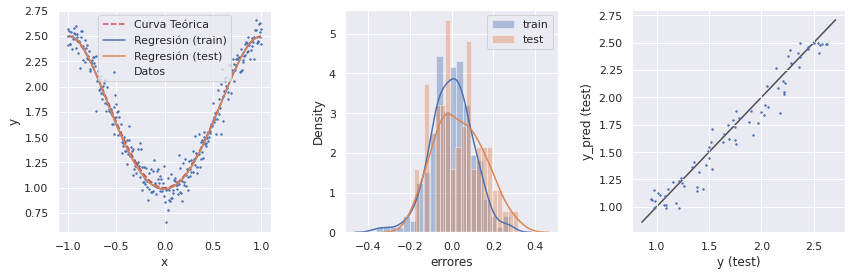

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 7
Agregamos atributos hasta la potencia x**7
Los atributos tienen forma: (300, 7)
Los coeficiones polinomicos son [-0.00618857  2.88590572  0.27602883 -1.07049215 -0.74149068 -0.31321897
  0.48335184] y su ordenada al origen 0.9854298022502055
Raíz del error cuadrático medio en Train: 0.10120699985902375
Raíz del error cuadrático medio en Test: 0.1194649752087484


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


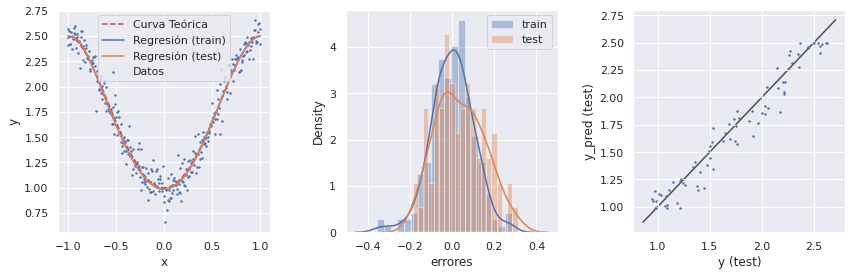

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 8
Agregamos atributos hasta la potencia x**8
Los atributos tienen forma: (300, 8)
Los coeficiones polinomicos son [-0.00625726  2.92299941  0.27566551 -1.27464254 -0.73951805  0.03880059
  0.48156229 -0.18717573] y su ordenada al origen 0.9844352386171465
Raíz del error cuadrático medio en Train: 0.10120248631167622
Raíz del error cuadrático medio en Test: 0.11961330501945971


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


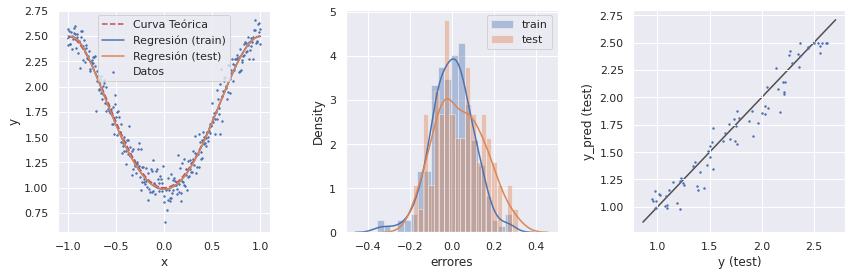

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 9
Agregamos atributos hasta la potencia x**9
Los atributos tienen forma: (300, 9)
Los coeficiones polinomicos son [ 0.02814223  2.92060938 -0.22229064 -1.26878014  1.16517247  0.02997658
 -2.1941438  -0.18110281  1.24491056] y su ordenada al origen 0.9846406453175827
Raíz del error cuadrático medio en Train: 0.1011530538930419
Raíz del error cuadrático medio en Test: 0.11976237729794116


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


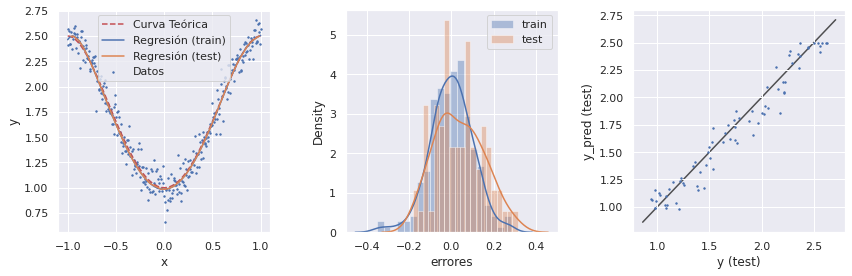

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 10
Agregamos atributos hasta la potencia x**10
Los atributos tienen forma: (300, 10)
Los coeficiones polinomicos son [  0.02867378   3.26499724  -0.23594322  -4.2776538    1.20902449
   8.99204499  -2.2520405  -10.94573583   1.27400075   4.49120945] y su ordenada al origen 0.978735098785132
Raíz del error cuadrático medio en Train: 0.1009977606739238
Raíz del error cuadrático medio en Test: 0.12093161199010329


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


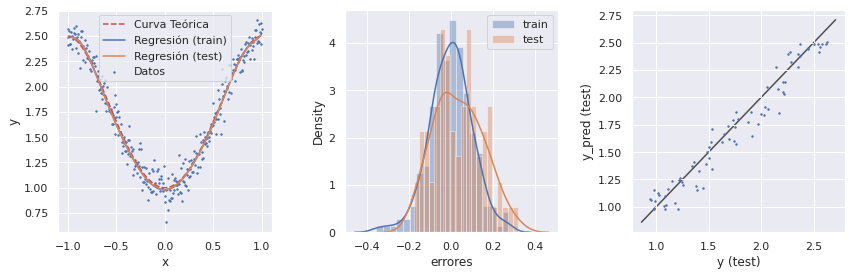

In [ ]:
for idx,potencia_maxima in enumerate(range(1,11)):
    print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {idx + 1}')
    print(f'Agregamos atributos hasta la potencia x**{potencia_maxima}')
    
    X = x.reshape(-1,1)
    for potencia in range(2,potencia_maxima+1):
        X = np.hstack((X,(x**potencia).reshape(-1,1)))  #es una forma de concatenar numpy arrays, en este caso ira concatenando los valores del polinomio de x https://numpy.org/doc/stable/reference/generated/numpy.hstack.html

    print(f'Los atributos tienen forma: {X.shape}')
    
    #entrena el X con los atributos nuevos polinomicos, es decir x, x¨2, x¨3...
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    
    ### ENTRENAMOS
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    print(f'Los coeficiones polinomicos son {reg.coef_} y su ordenada al origen {reg.intercept_}')
 
    
    evaluar_regresion(reg, x,y, X_train, X_test, y_train, y_test)


    #a mayor orden mejor se ajusta la ordenada al origen.
    #el orden de los coeficientes es x"1, x"2, x"3, x"4. hasta orden 5 no ajusta bien el coeficiente de x"4. 
    #a mayor orden que el de la relación funcional la tasa de error varia muy poco. por lo que la ganancia es marginal

    # si sigo agregando atributos puedo tender a un overfitting
    



## 2. `PolynomialFeatures`

En la práctica, no deberás agregar atributos polinómicos como hicimos en el ejemplo anterior, sino que podrás usar la clase `PolynomialFeatures` de Scikit-Learn. 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

**Lee atentamente su documentación y aplícala en el mismo problema de la sección 1**. Nosotros te guiamos en los pasos, pero si crees que no lo necesitas, puedes hacerlo en un notebook aparte o borrar las celdas con indicaciones.

**Atención:** Recordá que en estos ejercicios conocemos la forma real de los datos (el polinomio) porque los generamos nosotros. En la realidad no lo vas a conocer, por lo que el grado máximo a incoporar es un hiperparámetro.

1. Importa la clase `PolynomialFeatures`.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


2. Vuelve a definir `X` a partir de `x`, y haz un `train_test_split`.

In [ ]:
n = 300
x = np.linspace(-1,1,n)
y_real = -1.5*x**4+3*x**2+1
y = y_real + 0.1*np.random.randn(n)


X = x.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

print(f'los datos tienen tamaño {X_train.shape} y {X_test.shape} ')


los datos tienen tamaño (225, 1) y (75, 1) 


3. Crea un objeto a partir de `PolynomialFeatures` de suficiente `degree` para este problema. Aplícalo sobre `X_train` e `X_test`. Imprime en pantalla el `shape` de los nuevos conjuntos obtenidos.

In [ ]:
poly = PolynomialFeatures(degree = 5, include_bias=False) #el bias agrega una columna que es 1.  por default devuelve el verdadero.
#If True (default), then include a bias column, the feature in which all polynomial powers are zero (i.e. a column of ones - acts as an intercept term in a linear model).
#se usa para ver si agrega ruido



los nuevos datos tienen tamaño (225, 5) y (75, 5) 


4. Entrena una regresión lineal, observa los coeficientes obtenidos, y predice sobre el conjunto de Train y de Test.

In [ ]:
reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)

print(f'Los coeficiones polinomicos son {reg_2.coef_} y su ordenada al origen {reg_2.intercept_}')

y_train_pred_2 = reg_2.predict(X_train_new)
y_test_pred_2 = reg_2.predict(X_test_new)

Los coeficiones polinomicos son [-0.06265984  2.90118206  0.28372045 -1.40512786 -0.20929337] y su ordenada al origen 1.0173093878871105


5. Calcula el error RMSE sobre cada conjunto, grafica la curva obtenida, el histograma de los errores y la relación $y$ vs. $y_{pred}$ como hicimos en los ejemplos anteriores.

Raíz del error cuadrático medio en Train: 0.09261443878398092
Raíz del error cuadrático medio en Test: 0.09970088874569448


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


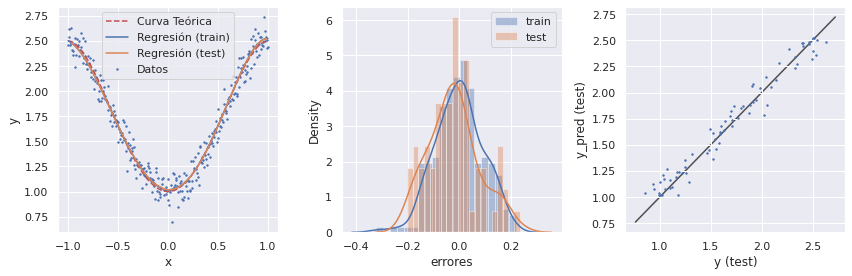

In [ ]:
evaluar_regresion(reg_2, x ,y, X_train_new, X_test_new, y_train, y_test)


### 3. Regularización

Esperamos haberte convencido de que crear nuevos atributos funciona. Sin embargo, este ejemplo que te mostramos es demasiado sencillo por varios motivos:
1. La relación entre los atributos y la variable a predecir es un polinomio de grado relativamente bajo. No solo eso, sino que además la conocemos.
2. Solamente contamos con una sola variable predictora, `x`, cuando en realidad podrían ser más de un atributo. Como mencionamos en la bitácora,**cuando agreguemos nuevos atributos, no solamente podemos considerar las potencias de cada atributo, sino también las interacciones - cosas de la forma $x_1 x_2$.**

No siempre sabremos hasta qué grado generar atributos ni si usar interraciones entre ellos. Es más, no siempre será un polinomio la relación entre $x$ e $y$, muchas veces directamente no tendremos claro qué tipo de relación es.

Por suerte, los polinomios suelen ser una buena aproximación a otras funciones. Si no funciona, **podemos generar atributos que no sean polinómicos**, pero eso es algo que deberás investigar por tu cuenta si alguna vez lo necesitas. Por ahora, **es suficiente que sepas que los atributos polinómicos no son la única opción, pero suelen ser una opción versátil.**

En lo que respecta al grado hasta el cual debemos agregar atributos, existe una técnica que nos permite controlar el error si nos pasamos un poco. Esta técnica se llama Regularización, y su alcance es mucho mayor que el aquí expuesto. Veamos cómo funciona.

Vamos a usar de referencia el modelo que entrenaste en la sección anterior. Por las dudas, lo vamos a dejar entrenado nuevamente aquí. Es importante que prestes atención a los coeficientes de esta regresión lineal.

Los coeficiones polinomicos son [  0.02867378   3.26499724  -0.23594322  -4.2776538    1.20902449
   8.99204499  -2.2520405  -10.94573583   1.27400075   4.49120945] y su ordenada al origen 0.978735098785132
Raíz del error cuadrático medio en Train: 0.09261443878398092
Raíz del error cuadrático medio en Test: 0.09970088874569448


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


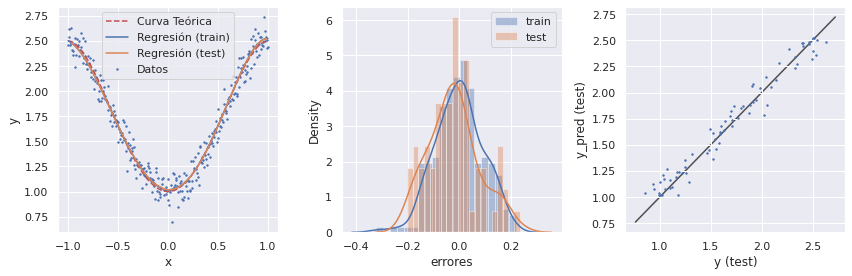

In [ ]:
poly = PolynomialFeatures(degree = 5,interaction_only=False, include_bias=False) ### ACA TENDRAS QUE MODIFICAR MAS ADELANTE ,interaction_only=False esto hace los productos cruzados.
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)

print(f'Los coeficiones polinomicos son {reg.coef_} y su ordenada al origen {reg.intercept_}')
 
    
evaluar_regresion(reg_2, x,y, X_train_new, X_test_new, y_train, y_test)

Ahora, vamos a entrenar dos regresiones sobre el mismo dataset, pero con regularización. Esto lo puedes hacer con las clases `Ridge` y `Lasso` de Scikit-Learn. Como siempre, es prácticamente obligatorio que consultes su documentación.

Empezamos entrenando el modelo `Ridge`. Presta atención a sus coeficientes:

In [ ]:
from sklearn.linear_model import Ridge, Lasso
#son regresiones lineales con esas formas de ajuste de los coeficientes
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

reg_ridge = Ridge(alpha= 0.1)
reg_ridge.fit(X_train_new,y_train)

print(f'Pendientes: {reg_ridge.coef_}')
print(f'Ordenada: {reg_ridge.intercept_}')

Pendientes: [-0.03845138  2.66999752  0.1777712  -1.1495141  -0.11657927]
Ordenada: 1.0426790130466022


Raíz del error cuadrático medio en Train: 0.0948469995911194
Raíz del error cuadrático medio en Test: 0.10192533922221622


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


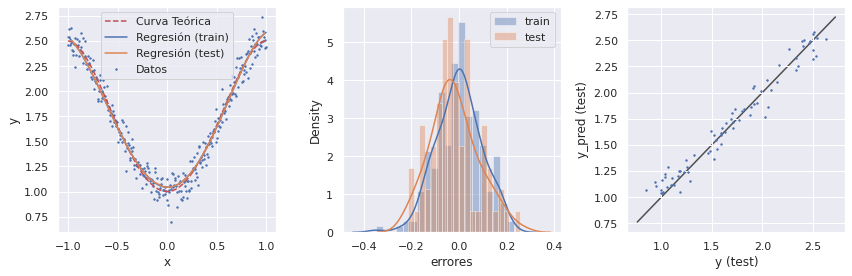

In [ ]:
evaluar_regresion(reg_ridge, x,y, X_train_new, X_test_new, y_train, y_test)

**Para Probar:** modifica el valor de `alpha` y observa su efecto. ¿Cómo cambian los coeficientes? **Tip:** varía en órdenes de magnitud,  (10, 5, 1, 0.5, 0.1 ,0.01, 0.005, 0.001, etc.).


Alpha: 10
Pendientes: [0.00699612 0.86640476 0.01979237 0.48642184 0.0114912 ]
Ordenada: 1.3134015914898058
Raíz del error cuadrático medio en Train: 0.2147909865161608
Raíz del error cuadrático medio en Test: 0.21242579229424738


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


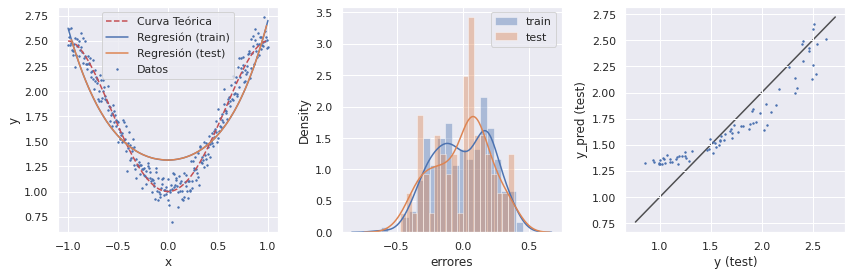

Alpha: 5
Pendientes: [0.00187981 1.07571559 0.02560948 0.42718344 0.01159612]
Ordenada: 1.255231910110885
Raíz del error cuadrático medio en Train: 0.18683691910620726
Raíz del error cuadrático medio en Test: 0.18695368264524512


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


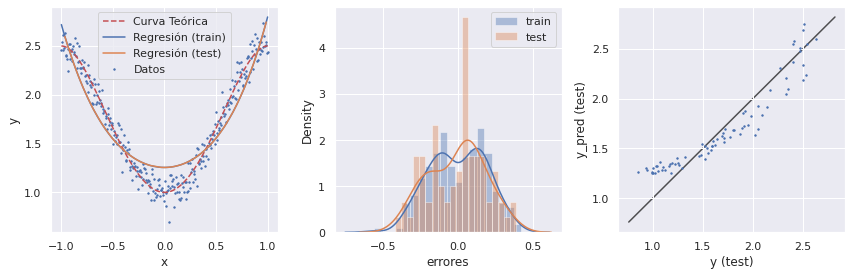

Alpha: 1
Pendientes: [-0.00991683  1.75647966  0.05460041 -0.16463662 -0.00735857]
Ordenada: 1.147813873739056
Raíz del error cuadrático medio en Train: 0.13596271583205594
Raíz del error cuadrático medio en Test: 0.1399645115395471


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


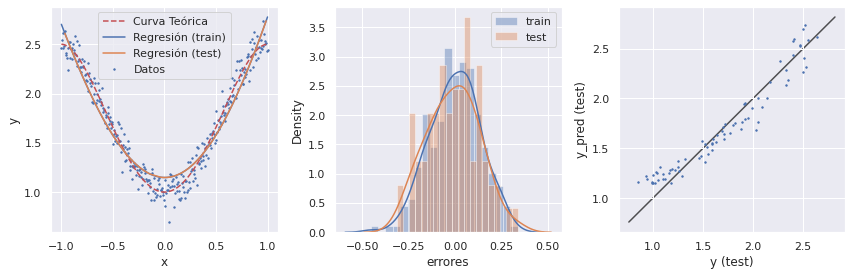

Alpha: 0.5
Pendientes: [-0.01636567  2.1071445   0.0808463  -0.5352357  -0.03051452]
Ordenada: 1.1059470727911482
Raíz del error cuadrático medio en Train: 0.11567395993176821
Raíz del error cuadrático medio en Test: 0.12113182146003579


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


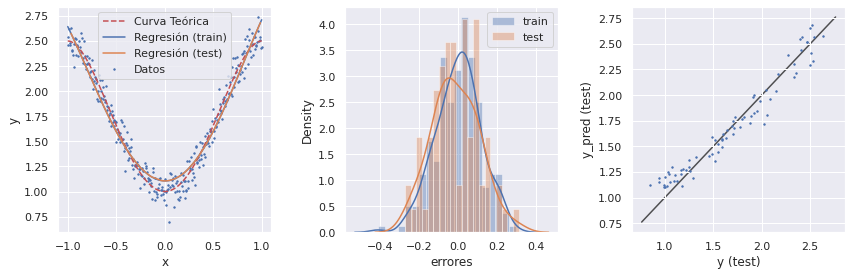

Alpha: 0.1
Pendientes: [-0.03845138  2.66999752  0.1777712  -1.1495141  -0.11657927]
Ordenada: 1.0426790130466022
Raíz del error cuadrático medio en Train: 0.0948469995911194
Raíz del error cuadrático medio en Test: 0.10192533922221622


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


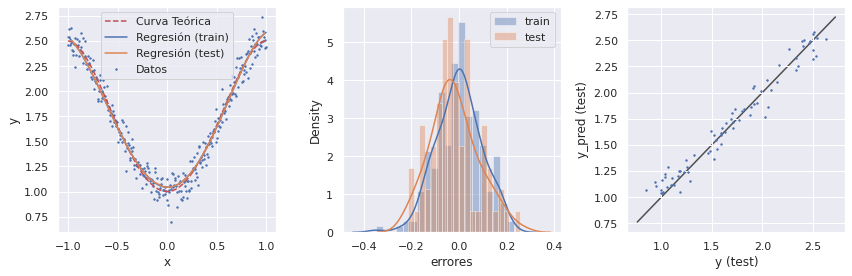

Alpha: 0.05
Pendientes: [-0.04749079  2.77857006  0.21742619 -1.26938717 -0.15138905]
Ordenada: 1.0307385321710796
Raíz del error cuadrático medio en Train: 0.09325633528554848
Raíz del error cuadrático medio en Test: 0.10040867848963113


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


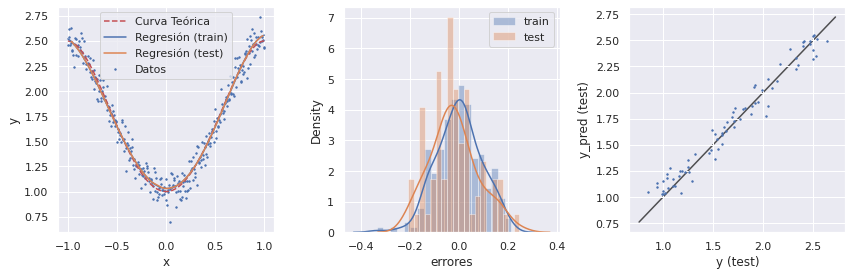

Alpha: 0.01
Pendientes: [-0.05885767  2.87540649  0.26712788 -1.37656135 -0.19482624]
Ordenada: 1.0201285651016945
Raíz del error cuadrático medio en Train: 0.092643446633245
Raíz del error cuadrático medio en Test: 0.09975855254732642


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


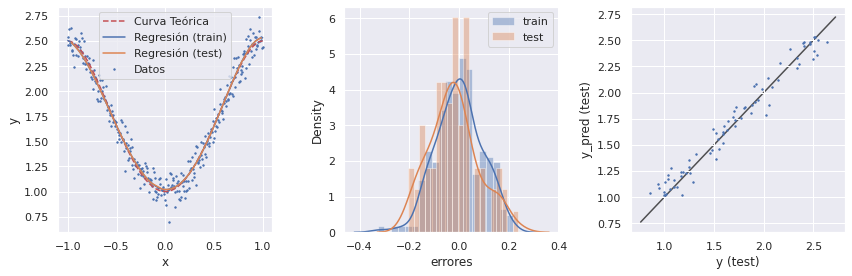

Alpha: 0.005
Pendientes: [-0.0606967   2.8882114   0.27515515 -1.3907507  -0.20182703]
Ordenada: 1.018727819397461
Raíz del error cuadrático medio en Train: 0.09262180953976201
Raíz del error cuadrático medio en Test: 0.09972373864511377


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


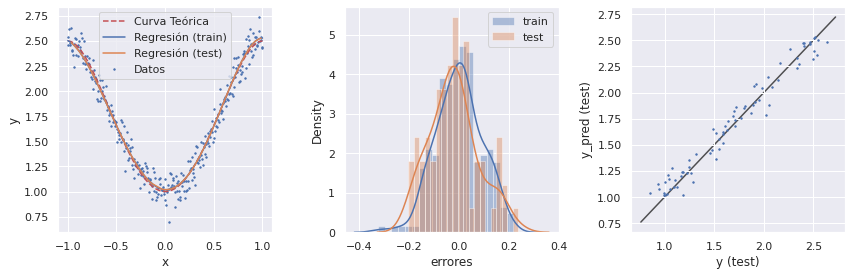

Alpha: 0.001
Pendientes: [-0.06225669  2.89857451  0.28196177 -1.40223723 -0.20776064]
Ordenada: 1.017594506595461
Raíz del error cuadrático medio en Train: 0.09261473753569761
Raíz del error cuadrático medio en Test: 0.09970447471509833


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


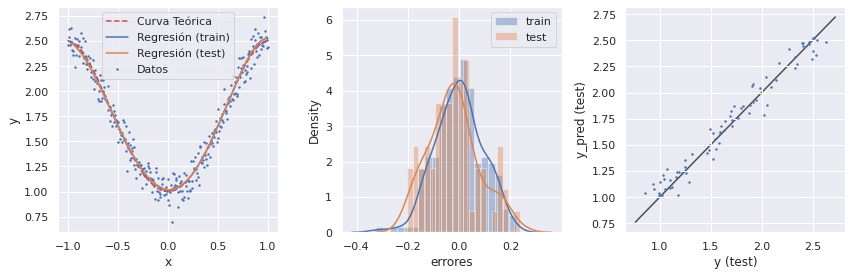

In [ ]:
for alpha in [10, 5, 1, 0.5, 0.1, 0.05 ,0.01, 0.005, 0.001]: 
  #alpha: Regularization strength; must be a positive float.
  #Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization.
  reg_ridge = Ridge(alpha= alpha)
  reg_ridge.fit(X_train_new,y_train)

  print(f'Alpha: {alpha}')
  print(f'Pendientes: {reg_ridge.coef_}')
  print(f'Ordenada: {reg_ridge.intercept_}')

  evaluar_regresion(reg_ridge, x,y, X_train_new, X_test_new, y_train, y_test)



Ahora, el modelo `Lasso`:

In [ ]:
reg_lasso = Lasso(alpha = 0.001)
#alpha Constant that multiplies the L1 term. Defaults to 1.0. alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object
reg_lasso.fit(X_train_new,y_train)
print(reg_lasso.coef_, reg_lasso.intercept_)

[ 0.          2.62281719  0.02709402 -1.09176552  0.        ] 1.0468831019898968


Raíz del error cuadrático medio en Train: 0.09621203219784982
Raíz del error cuadrático medio en Test: 0.102801906208291


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


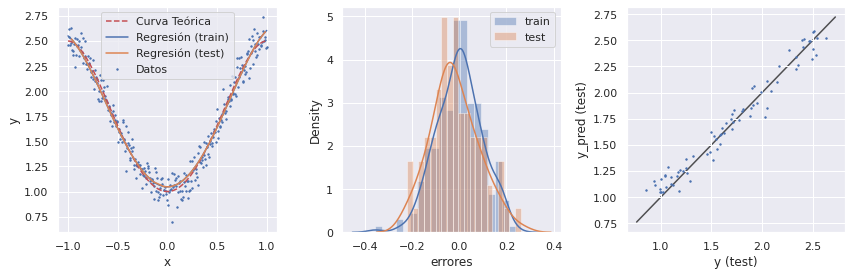

In [ ]:
evaluar_regresion(reg_lasso, x,y, X_train_new, X_test_new, y_train, y_test)

**Para Probar:** nuevamente, modifica el valor de `alpha` y observa su efecto. ¿Cómo cambian los coeficientes?¿Notas alguna diferencia con el modelo `Ridge`? ¡Hay una diferencia importante, que hace que la regresión `Lasso` sea muy apreciada!

Alpha: 10
Pendientes: [0. 0. 0. 0. 0.]
Ordenada: 1.7042609279001595
Raíz del error cuadrático medio en Train: 0.5359264841137525
Raíz del error cuadrático medio en Test: 0.5161862402770419


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


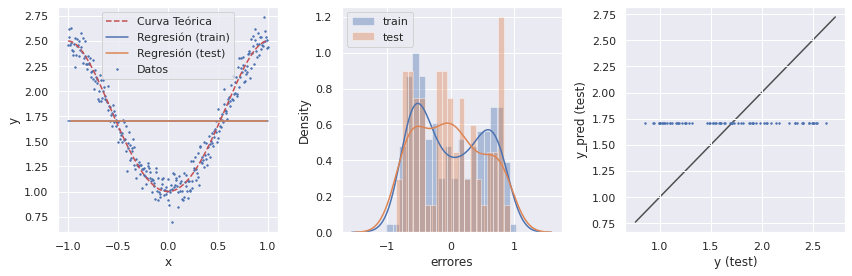

Alpha: 5
Pendientes: [0. 0. 0. 0. 0.]
Ordenada: 1.7042609279001595
Raíz del error cuadrático medio en Train: 0.5359264841137525
Raíz del error cuadrático medio en Test: 0.5161862402770419


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


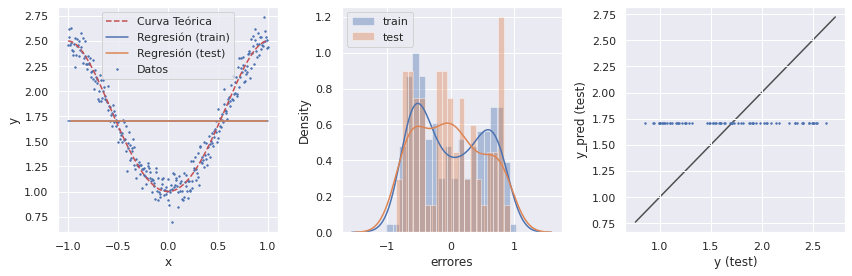

Alpha: 1
Pendientes: [0. 0. 0. 0. 0.]
Ordenada: 1.7042609279001595
Raíz del error cuadrático medio en Train: 0.5359264841137525
Raíz del error cuadrático medio en Test: 0.5161862402770419


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


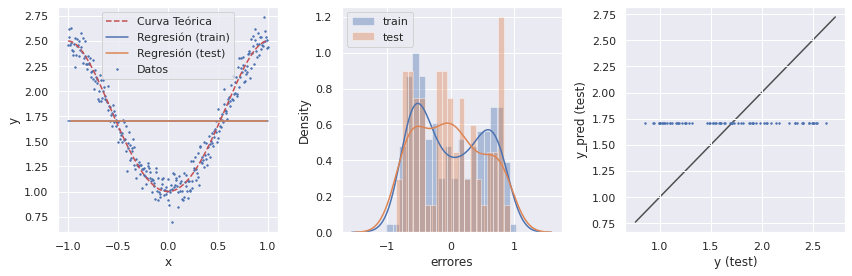

Alpha: 0.5
Pendientes: [0. 0. 0. 0. 0.]
Ordenada: 1.7042609279001595
Raíz del error cuadrático medio en Train: 0.5359264841137525
Raíz del error cuadrático medio en Test: 0.5161862402770419


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


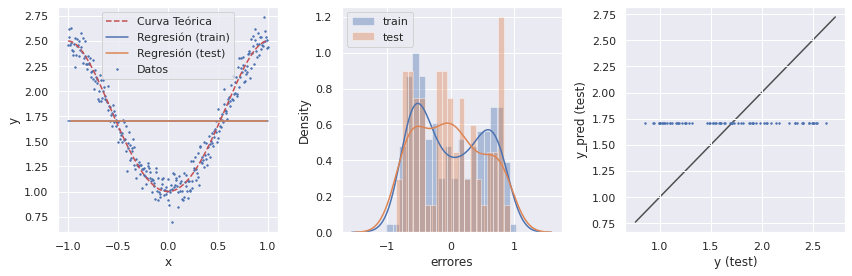

Alpha: 0.1
Pendientes: [0.         0.61550278 0.         0.         0.        ]
Ordenada: 1.4975504803489559
Raíz del error cuadrático medio en Train: 0.35949563001065205
Raíz del error cuadrático medio en Test: 0.34841273810670914


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


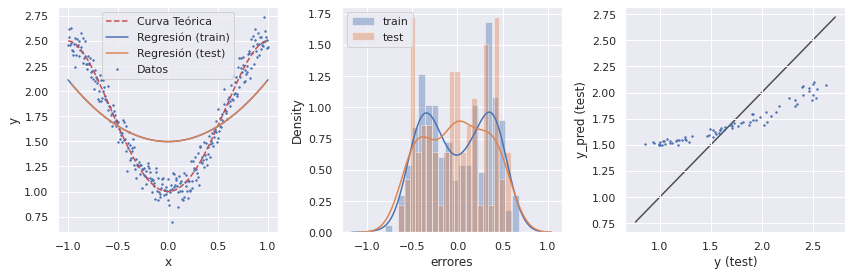

Alpha: 0.05
Pendientes: [0.         1.15857723 0.         0.         0.        ]
Ordenada: 1.315164359495033
Raíz del error cuadrático medio en Train: 0.2185770793251681
Raíz del error cuadrático medio en Test: 0.21523513735278746


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


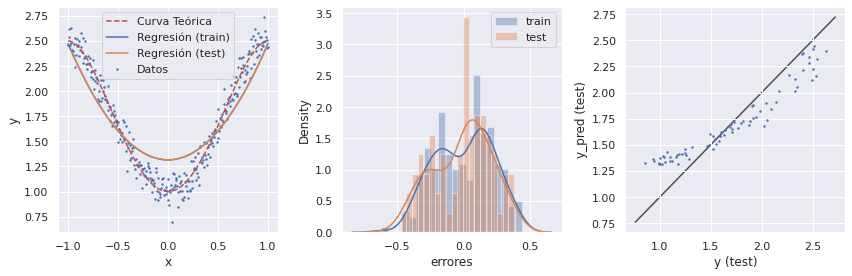

Alpha: 0.01
Pendientes: [0.        1.5930368 0.        0.        0.       ]
Ordenada: 1.1692554628118947
Raíz del error cuadrático medio en Train: 0.1473375909989765
Raíz del error cuadrático medio en Test: 0.14831002106386745


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


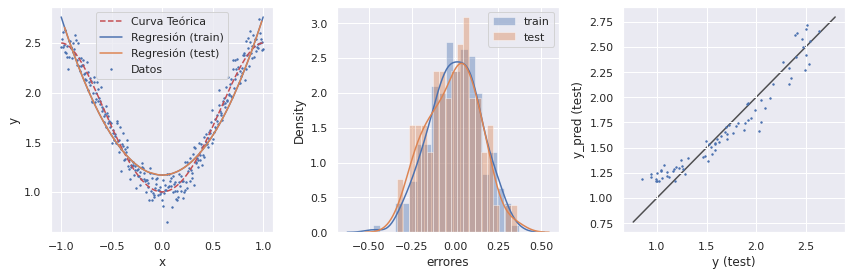

Alpha: 0.005
Pendientes: [ 0.00471847  1.64709382  0.         -0.          0.        ]
Ordenada: 1.1510728285657112
Raíz del error cuadrático medio en Train: 0.1443662115193301
Raíz del error cuadrático medio en Test: 0.14582450339971603


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


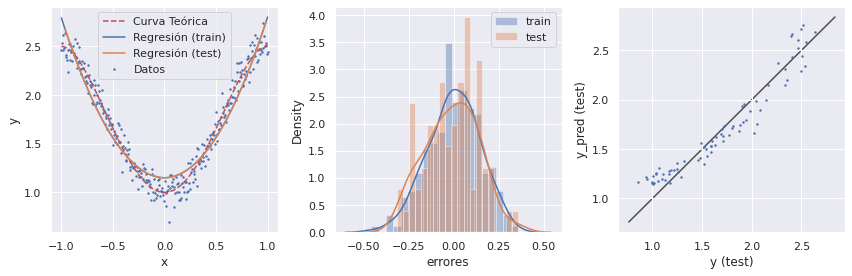

Alpha: 0.001
Pendientes: [ 0.          2.62281719  0.02709402 -1.09176552  0.        ]
Ordenada: 1.0468831019898968
Raíz del error cuadrático medio en Train: 0.09621203219784982
Raíz del error cuadrático medio en Test: 0.102801906208291


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


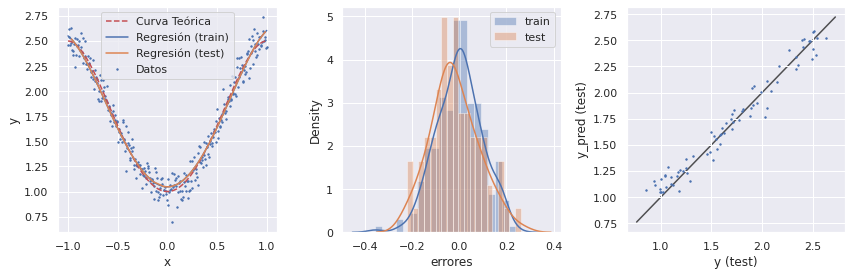

In [ ]:
for alpha in [10, 5, 1, 0.5, 0.1, 0.05 ,0.01, 0.005, 0.001]: 
  reg_lasso = Lasso(alpha = alpha)
  reg_lasso.fit(X_train_new,y_train)

  print(f'Alpha: {alpha}')
  print(f'Pendientes: {reg_lasso.coef_}')
  print(f'Ordenada: {reg_lasso.intercept_}')
  evaluar_regresion(reg_lasso, x,y, X_train_new, X_test_new, y_train, y_test)

#utiliza menos coeficientes que ridge, se ajusta a una forma funcional de los datos. es decir que primero (de mayor alpha a menor) va usando el polinomio de grado 0 luego 2, luego ajusta mas a 6..
#aunque el error es un poco mayor, la ganancia computacional de usar pocos coeficientes ayuda a mejorar su rendimiento



**¿Qué pasa por fuera del rango de entrenamiento?**

Estamos entrenando una regresión en un rango de $x$ entre -1 y 1. ¿Pero qué pasa si entrenamos en ese rango, y queremos ver cómo es la regresión por fuera? Es decir, para valores más grandes y más chicos que -1 y 1, respectivamente.

Vamos a usar los modelos obtenidos para predecir por fuera de ese rango. Por las dudas, **reentrena los modelos `ridge` y `lasso` con valores de `alpha` razonables.** Si tuvieras que apostar, ¿cuál modelo te parece más robusto?

In [ ]:
#stefi puso fit de ridge y lasso

#reg_ridge=Ridge(alpha=0.1)
#reg_ridge=



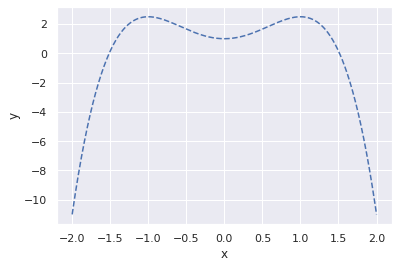

In [ ]:
x_nuevo_rango = np.linspace(-2,2,1000)
y_nuevo_rango = -1.5*x_nuevo_rango**4+3*x_nuevo_rango**2+1

plt.plot(x_nuevo_rango, y_nuevo_rango, '--')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
X_nuevo_rango = poly.fit_transform(x_nuevo_rango.reshape(-1,1))

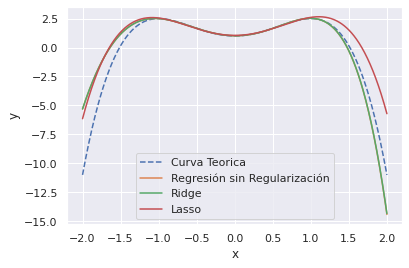

In [ ]:
plt.plot(x_nuevo_rango, y_nuevo_rango, '--', label = 'Curva Teorica')
plt.plot(x_nuevo_rango, reg_2.predict(X_nuevo_rango), label = 'Regresión sin Regularización')
plt.plot(x_nuevo_rango, reg_ridge.predict(X_nuevo_rango), label = 'Ridge')
plt.plot(x_nuevo_rango, reg_lasso.predict(X_nuevo_rango), label = 'Lasso')
plt.legend()

### SI NO PUEDE VISUALIZAR CORRECTAMENTE, DESCOMENTA ESTAS LINEAS 
### Y PRUEBA DISTINTOS VALORES PARA LOS LIMITES

plt.xlabel('x')
plt.ylabel('y')
plt.show()

#el error aumenta hacia los extremos de la distribución.


#esto es para ver como generaliza el modelo cuando me voy más alla de mis rango de datos.

Tal vez el ejemplo por ahora no te parezca muy impresionante. De alguna forma, todos los modelos dan resultados muy parecidos. Pero recuerda lo siguiente: nosotros sabemos cómo es la relación funcional de los datos, un polinomio de grado 4. Cuando agregamos atributos, lo estamos haciendo hasta grado 7, lo cual no es mucho más grande que el grado original. 

**Para Probar:** Para ver el verdadero efecto de la regularización, agrega atributos polinómicos hasta un grado alto, por ejemplo 50, 100, 150 ó más. Vuelve a correr la regresión sin regularización, y la regresión Ridge y Lasso, y fíjate qué sucede. Tal vez puedes volver a probar con algunos valores nuevos de `alpha`.


In [ ]:
#ver lo que hizo estefi
x_nuevo_rango = np.linspace(-2,2,1000)
y_nuevo_rango = -1.5*x_nuevo_rango**4+3*x_nuevo_rango**2+1

X = x_nuevo_rango.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
        X, y_nuevo_rango, test_size=0.25, random_state=42)

poly = PolynomialFeatures(degree = 100, include_bias=False)
X_nuevo_rango = poly.fit_transform(X)


X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)


reg_ridge = Ridge(alpha= 0.01)
reg_ridge.fit(X_train_new,y_train)



reg_lasso = Lasso(alpha = 0.01)
reg_lasso.fit(X_train_new,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.085945031872185, tolerance: 0.7284909733883131
  positive)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

ValueError: ignored

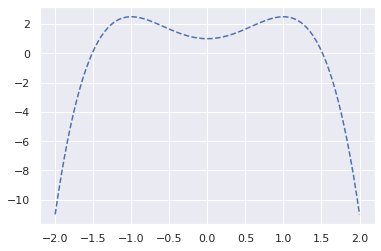

In [ ]:
x_nuevo_rango = np.linspace(-2,2,100)
y_nuevo_rango = -1.5*x_nuevo_rango**4+3*x_nuevo_rango**2+1

plt.plot(x_nuevo_rango, y_nuevo_rango, '--', label = 'Curva Teorica')
plt.plot(x_nuevo_rango, reg_2.predict(X_nuevo_rango), label = 'Regresión sin Regularización')
plt.plot(x_nuevo_rango, reg_ridge.predict(X_nuevo_rango), label = 'Ridge')
plt.plot(x_nuevo_rango, reg_lasso.predict(X_nuevo_rango), label = 'Lasso')
plt.legend()




## Conclusiones

Es posible ajustar relaciones no-lineales con un modelo lineal, pero tiene un costo: agregar nuevos atributos. Esto no solo hace crecer de manera considerable nuestro dataset, sino que además introduce un nuevo hiperparámetro, el grado hasta el cual agregamos atributos. Esto se soluciona parcialmente con regularización, pero a costa de otro hiperparámetro, la fuerza de la regularización, $\alpha$. Para colmo, estos hiperparámetros que acabamos de mencionar de alguna forma interactuan: a más atributos agreguemos, $\alpha$ probablemente deba tomar otro valor.

Como si esto no fuera poco, hay que tener mucho cuidado cuando usamos un modelo de regresión entrenado en un rango para predecir por fuera de ese rango. Como verás, las cosas pueden andar muy mal. Por suerte, esto no es un problema en muchas aplicaciones, pero es algo a lo que debes estar atento/a.


## 4. Ejercitación   terminar

Si todavía no estás muy cansado/a, puedes intentar hacer algunos de - o todos - los siguientes ejercicios:
1. Experimenta con alguna técnica para visualizar los coeficientes de una regresión, de forma tal de poder observar los efectos de la regularización en ellos.


como la grafica de la clase. ver extra que dio estefi


1. Puedes aplicar lo que vimos hoy en cualquiera de los dos datasets que te dejamos para descargar en la bitácora. Son datasets sintéticos, pero te servirán como práctica más realista de estas herramientas.
1. ¿Recuerdas el Proyecto del Bloque 01? ¡Aplica lo aprendido en ese dataset!

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd38d9325c0>,
      dtype=object)

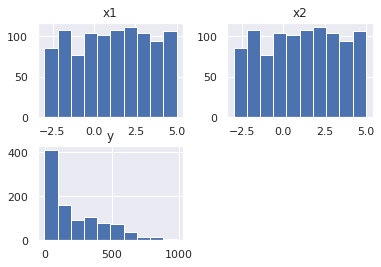

In [ ]:

data1=pd.read_csv('/content/drive/My Drive/Colab Notebooks/DS_Bitácora_23_Data1.csv', sep=',',engine='python')
data2=pd.read_csv('/content/drive/My Drive/Colab Notebooks/DS_Bitácora_23_Data2.csv', sep=',',engine='python')

data1.hist()

(1000,)

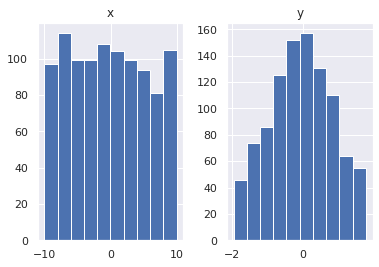

In [ ]:

data2.hist()
X=data2['x']

y=data2['y']
X.shape


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)


poly = PolynomialFeatures(degree = 6)
X = poly.fit_transform(X)
print(X.shape)

X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)

reg_ridge = Ridge(alpha= 0.001)
reg_ridge.fit(X_train_new,y_train)

reg_lasso = Lasso(alpha = 0.001)
reg_lasso.fit(X_train_new,y_train)
    


y_train_pred_r = pd.DataFrame(reg_2.predict(X_train_new))
y_test_pred_r = pd.DataFrame(reg_2.predict(X_test_new))

y_train_pred_R = pd.DataFrame(reg_ridge.predict(X_train_new))
y_test_pred_R = pd.DataFrame(reg_ridge.predict(X_test_new))

y_train_pred_L = pd.DataFrame(reg_lasso.predict(X_train_new))
y_test_pred_L = pd.DataFrame(reg_lasso.predict(X_test_new))


ValueError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<function matplotlib.pyplot.tight_layout>

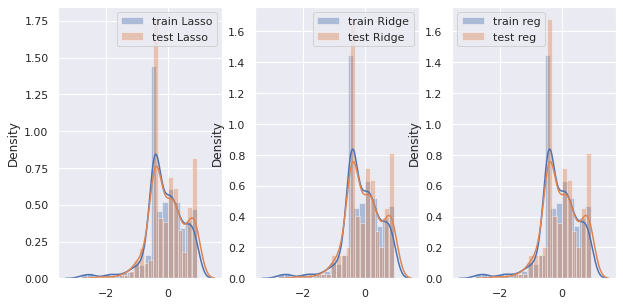

In [ ]:

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.distplot(y_train_pred_L, bins = 20, label = 'train Lasso')
sns.distplot(y_test_pred_L, bins = 20, label = 'test Lasso')
plt.legend()
plt.subplot(1,3,2)
sns.distplot(y_train_pred_R, bins = 20, label = 'train Ridge')
sns.distplot(y_test_pred_R, bins = 20, label = 'test Ridge')
plt.legend()
plt.subplot(1,3,3)
sns.distplot(y_train_pred_r, bins = 20, label = 'train reg')
sns.distplot(y_test_pred_r, bins = 20, label = 'test reg')
plt.legend()

plt.tight_layout

In [ ]:
print(X_train.shape)
print(y_train_pred_r.shape)

(750, 1)
(750, 1)


Raíz del error cuadrático medio en Train: 0.6129665412974507
Raíz del error cuadrático medio en Test: 0.613653549320633


ValueError: ignored

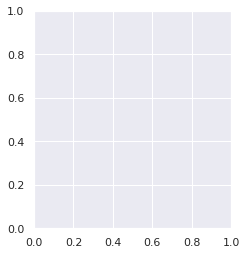

In [ ]:

evaluar_regresion(reg_ridge, X,y, X_train_new, X_test_new, y_train, y_test)